## Lab Tutorial - Variational Auto Encoder
1) mnist dataset: 10 digit classes, 60,000 training samples, 10,000 test sample

2) we create [encoder - decoder] structure.
- Loss: Recontruction error + Regularization.

3) Train the model -> put test image to encoder -> feature representation in latent space

4) We will randomly sample the latent variable -> decoder

5) From the specific range in latent space, we will sequentially sample the latent variable then we generate the images.

=======================================================================

# Conditional VAE


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
import numpy as np

(60000, 28, 28) (60000,)


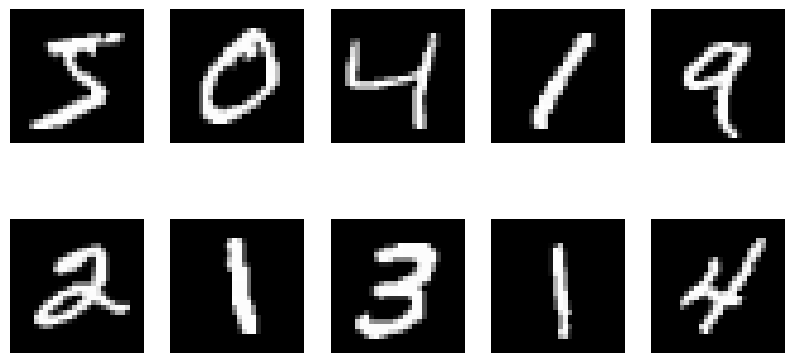

In [3]:
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST data (this time, keeping the labels)
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape, y_train.shape)
# Image size
image_size = x_train.shape[1]

# Reshape and normalize the data
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


# Plot some sample images from the MNIST dataset
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(x_train[i].reshape(image_size, image_size), cmap='gray')
    ax.axis('off')
plt.show()


## AE with conv layer

In [5]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from tensorflow.keras import backend as K

input_shape = (image_size, image_size, 1)
latent_dim = 2  # Dimensionality of the latent space

# Encoder architecture
inputs = Input(shape=input_shape, name='encoder_input')
x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

# Shape info needed to build decoder model
shape = K.int_shape(x)

# Generate the latent vector
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# Instantiate the encoder
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# Decoder architecture
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
outputs = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Instantiate the decoder
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
# VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')
vae.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 28, 28, 32)     │            320 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 14, 14, 32)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 14, 14, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 7, 7, 64)       │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 7, 7, 128)      │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 4, 4, 128)      │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 2048)           │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │      1,049,088 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │          1,026 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │          1,026 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z (Lambda)                │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,143,812 (4.36 MB)

 Trainable params: 1,143,812 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ z_sampling (InputLayer)              │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2048)                │           6,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 14, 14, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

Model: "vae_mlp"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Functional)                 │ [(None, 2), (None, 2),      │       1,143,812 │
│                                      │ (None, 2)]                  │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 28, 28, 1)           │         246,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,390,085 (5.30 MB)

 Trainable params: 1,390,085 (5.30 MB)

 Non-trainable params: 0 (0.00 B)

## Find a total loss and guess what happend if you remove kl_loss (AE).

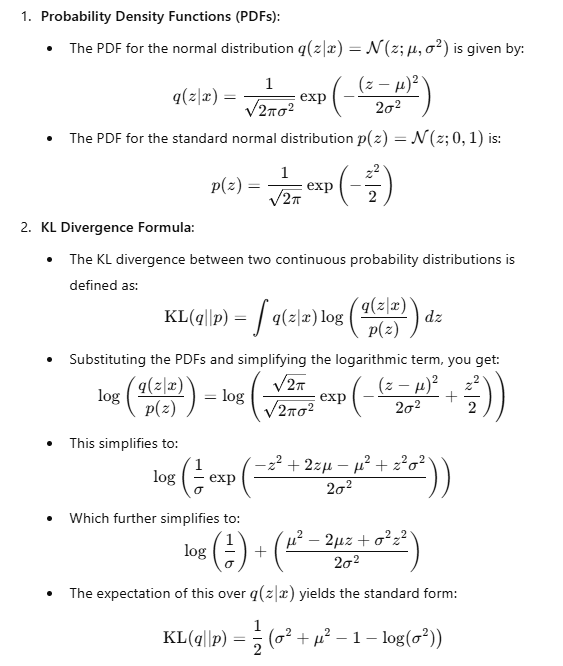

In [6]:
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= image_size * image_size
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss  + kl_loss  ##

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

# Instantiate the VAE model
vae = VAE(encoder, decoder)
vae.compile(optimizer='adam')


In [7]:
vae.fit(x_train, epochs=1, batch_size=128)

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - kl_loss: 2.9334 - loss: 182.0791 - reconstruction_loss: 179.1456


## Feature distribution for test dataset in latent space

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


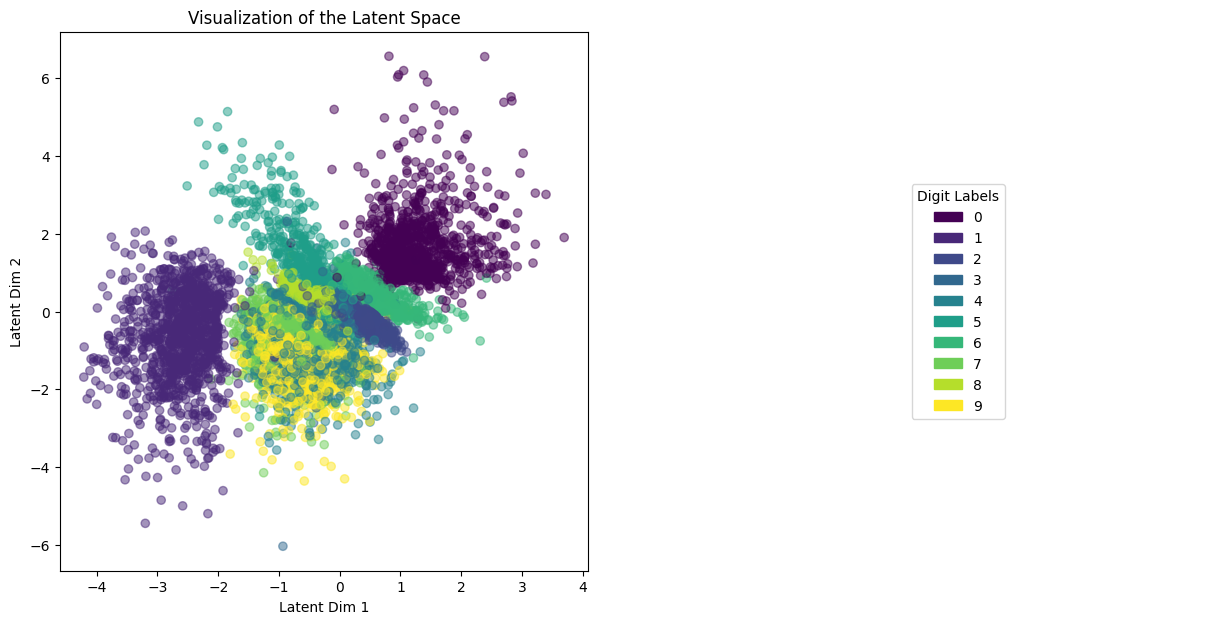

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
z_mean, _, _ = encoder.predict(x_test)
def plot_latent_space_with_label_info(z_mean, labels, figsize=(15, 7)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    # Plotting the latent space
    scatter = ax1.scatter(z_mean[:, 0], z_mean[:, 1], c=labels, cmap='viridis', alpha=0.5)
    ax1.set_xlabel('Latent Dim 1')
    ax1.set_ylabel('Latent Dim 2')
    ax1.set_title('Visualization of the Latent Space')

    # Creating a color legend for labels
    unique_labels = np.unique(labels)
    handles = [mpatches.Patch(color=plt.cm.viridis(label / max(unique_labels)), label=label) for label in unique_labels]
    ax2.legend(handles=handles, title="Digit Labels", loc='center')
    ax2.axis('off')

    plt.show()

plot_latent_space_with_label_info(z_mean, y_test)


## We sample n random numbers from standard normal distributoin, then let decoder generate n images.  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step


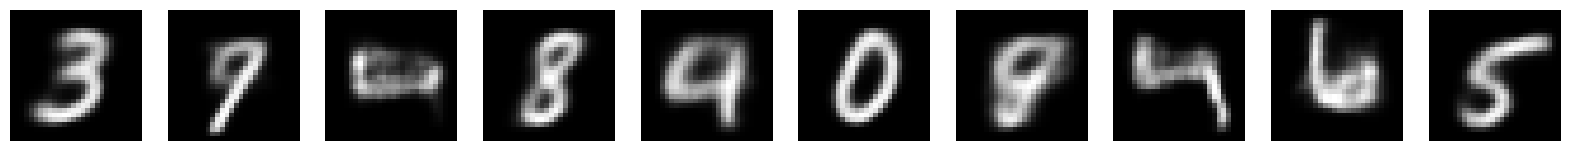

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def plot_images(decoded_images, n=10, figsize=(20, 4)):
    plt.figure(figsize=figsize)
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(decoded_images[i].reshape(image_size, image_size))
        plt.gray()
        ax.axis('off')
    plt.show()

# Sampling from the latent space
n = 10  # Number of samples
z_sample = np.random.normal(size=(n, latent_dim))

# Decode the sampled points
decoded_images = decoder.predict(z_sample)

# Plot the generated images
plot_images(decoded_images, n=n)


## We sample the sequential value in the specific area, then generate output images. Check if the generated images are corresponding to the latent distribution.

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


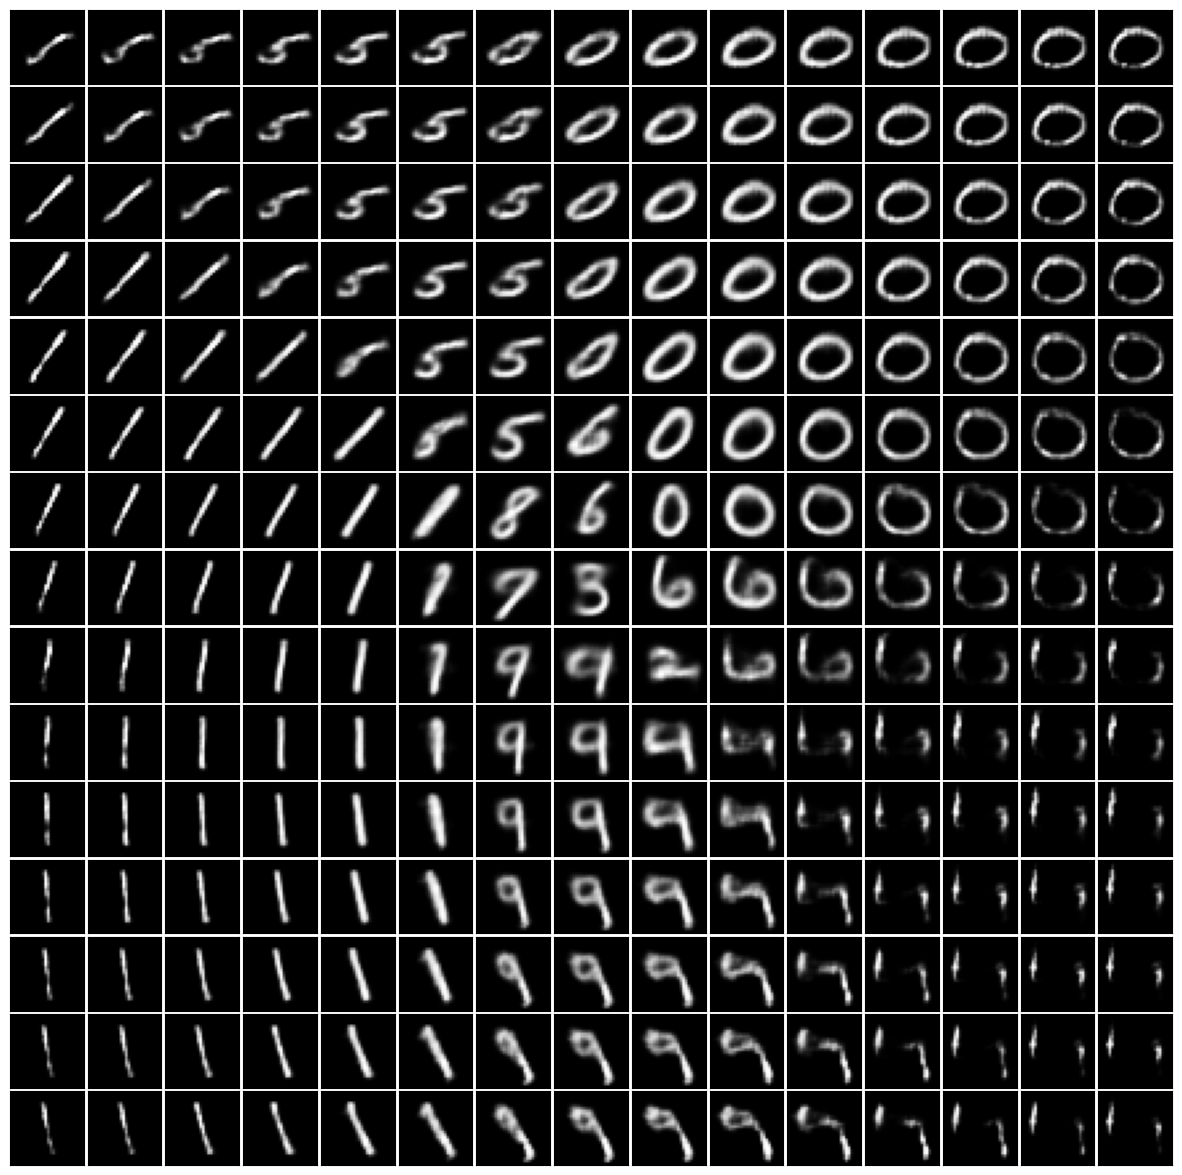

In [11]:

# Parameters for the grid
n = 15  # Number of points per dimension
grid_start = -6  # Start of the grid
grid_end = 6  # End of the grid

# Creating a grid of points in the latent space
grid_x = np.linspace(grid_start, grid_end, n)
grid_y = np.linspace(grid_end, grid_start, n)  # Reversed order for y
grid = np.array([[x, y] for y in grid_y for x in grid_x])  # Note the order of loops
decoded_images = decoder.predict(grid)

import matplotlib.pyplot as plt

def plot_latent_space_images(images, grid_size, figsize=(15, 15)):
    fig, axes = plt.subplots(grid_size, grid_size, figsize=figsize, subplot_kw={'xticks':[], 'yticks':[]})
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i].reshape(image_size, image_size), cmap='gray')

plot_latent_space_images(decoded_images, n)



-----------------------------------------
## How to increase the model representation? Let's use class lable
- How, where to add classification loss?

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Conv2D, MaxPooling2D, Reshape, UpSampling2D
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Training loop

image_size = 28
latent_dim = 2
num_classes = 10

# Encoder architecture
inputs = Input(shape=(image_size, image_size, 1), name='encoder_input')
x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
shape = tf.keras.backend.int_shape(x)

x = Flatten()(x)
x = Dense(512, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, name='z')([z_mean, z_log_var])

# Encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

# Classifier on latent space
latent_inputs = Input(shape=(latent_dim,), name='latent_input')
x = Dense(128, activation='relu')(latent_inputs)
latent_classifier_outputs = Dense(num_classes, activation='softmax', name='latent_classifier_output')(x)
classifier_model = Model(latent_inputs, latent_classifier_outputs, name='latent_classifier')

# Decoder architecture
latent_inputs_decoder = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs_decoder)
x = Reshape((shape[1], shape[2], shape[3]))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
outputs = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

decoder = Model(latent_inputs_decoder, outputs, name='decoder')

# VAE model class
class VAE(Model):
    def __init__(self, encoder, decoder, classifier, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.classifier = classifier

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        classification = self.classifier(z_mean)

        # Add losses
        reconstruction_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(inputs, reconstruction)
        ) * image_size * image_size

        kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))

        self.add_loss(reconstruction_loss)
        self.add_loss(kl_loss)

        return reconstruction, classification

# Instantiate and compile VAE model
vae = VAE(encoder, decoder, classifier_model)
vae.compile(
    optimizer='adam',
    loss=[
        tf.keras.losses.BinaryCrossentropy(),
        tf.keras.losses.CategoricalCrossentropy()
    ]
)

# Summary
encoder.summary()
decoder.summary()
classifier_model.summary()

# Training loop
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_train = tf.expand_dims(x_train, axis=-1)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)

vae.fit(
    x_train,
    [x_train, y_train],
    epochs=30,
    batch_size=128,
    validation_split=0.2
)

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 28, 28, 32)     │            320 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 14, 14, 32)     │              0 │ conv2d_28[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_29 (Conv2D)        │ (None, 14, 14, 64)     │         18,496 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_13          │ (None, 7, 7, 64)       │              0 │ conv2d_29[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_30 (Conv2D)        │ (None, 7, 7, 128)      │         73,856 │ max_pooling2d_13[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_14          │ (None, 4, 4, 128)      │              0 │ conv2d_30[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_4 (Flatten)       │ (None, 2048)           │              0 │ max_pooling2d_14[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 512)            │      1,049,088 │ flatten_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │          1,026 │ dense_11[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │          1,026 │ dense_11[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z (Lambda)                │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,143,812 (4.36 MB)

 Trainable params: 1,143,812 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ z_sampling (InputLayer)              │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 2048)                │           6,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_4 (Reshape)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 4, 4, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_12 (UpSampling2D)      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 8, 8, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_13 (UpSampling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 14, 14, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_14 (UpSampling2D)      │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

Model: "latent_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ latent_input (InputLayer)            │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent_classifier_output (Dense)     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,674 (6.54 KB)

 Trainable params: 1,674 (6.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - binary_crossentropy_loss: 0.2890 - categorical_crossentropy_loss: 2.0903 - loss: 231.4158 - val_binary_crossentropy_loss: 0.2011 - val_categorical_crossentropy_loss: 1.3148 - val_loss: 162.2640
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - binary_crossentropy_loss: 0.1981 - categorical_crossentropy_loss: 1.2359 - loss: 159.8627 - val_binary_crossentropy_loss: 0.1900 - val_categorical_crossentropy_loss: 1.0305 - val_loss: 153.4953
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - binary_crossentropy_loss: 0.1894 - categorical_crossentropy_loss: 1.0132 - loss: 153.0494 - val_binary_crossentropy_loss: 0.1859 - val_categorical_crossentropy_loss: 0.9035 - val_loss: 150.3194
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - binary_crossentropy_loss: 0.1846 - categorical_crossentropy_loss: 0.8955 - loss: 149.2372 - val_binary_crossentropy_loss: 0.1826 - val_categorical_crossentropy_loss: 0.8382 - val_loss: 147.6896
Epo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


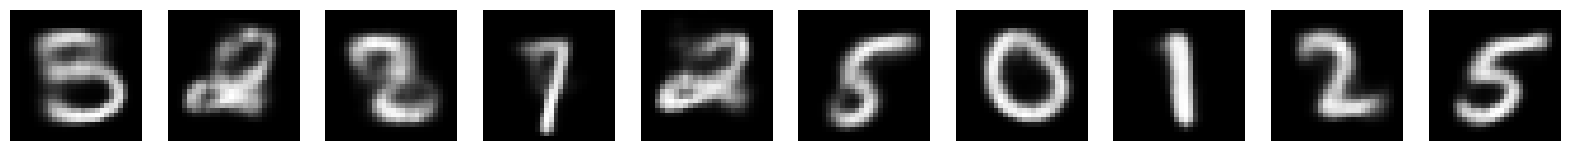

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


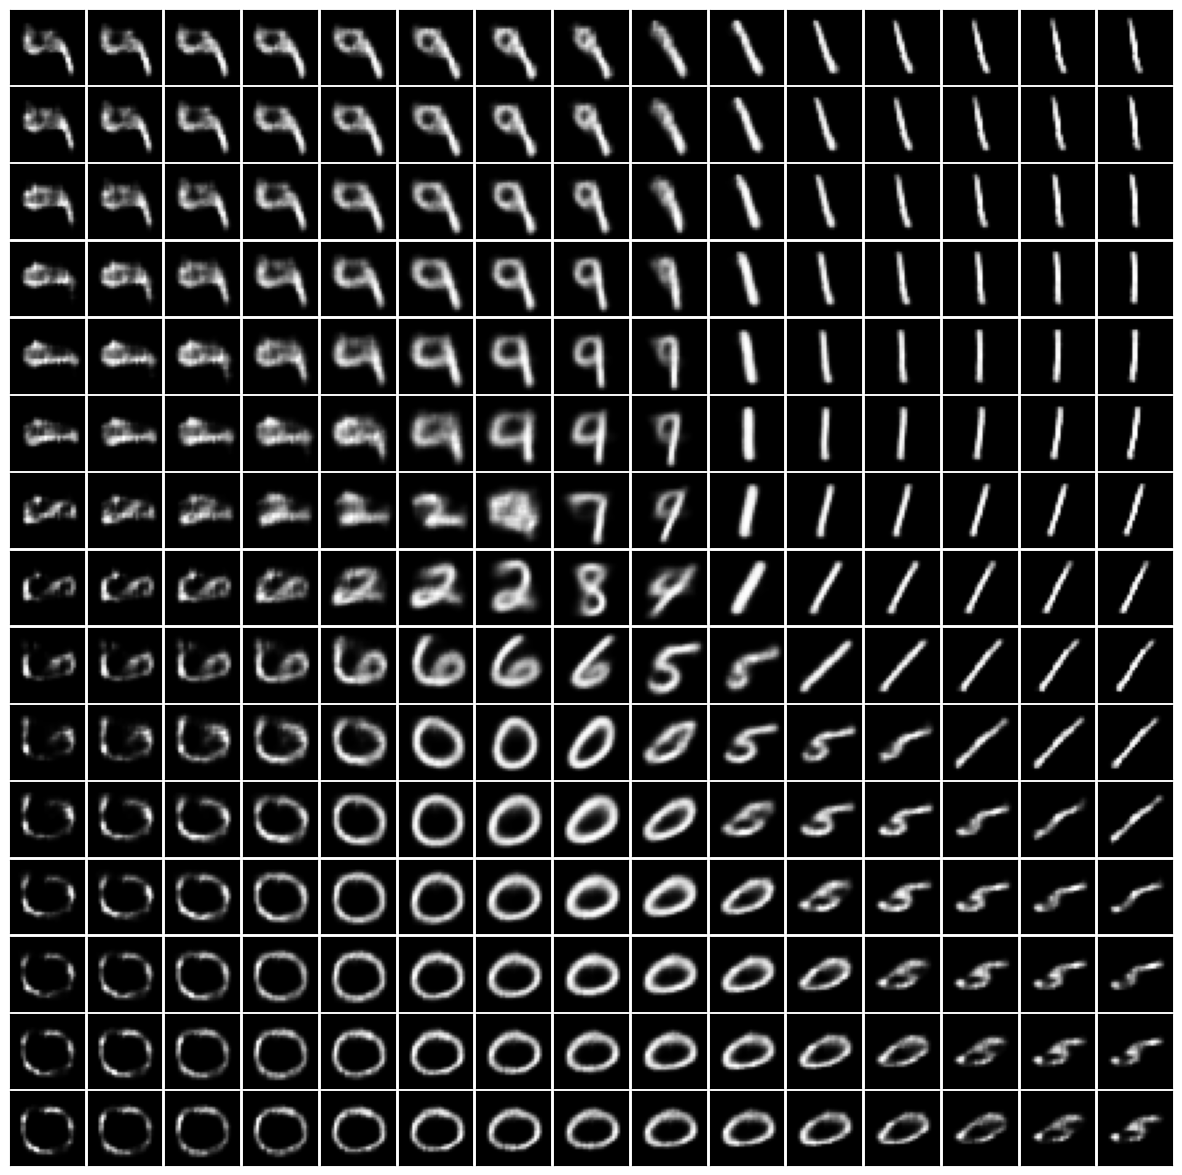

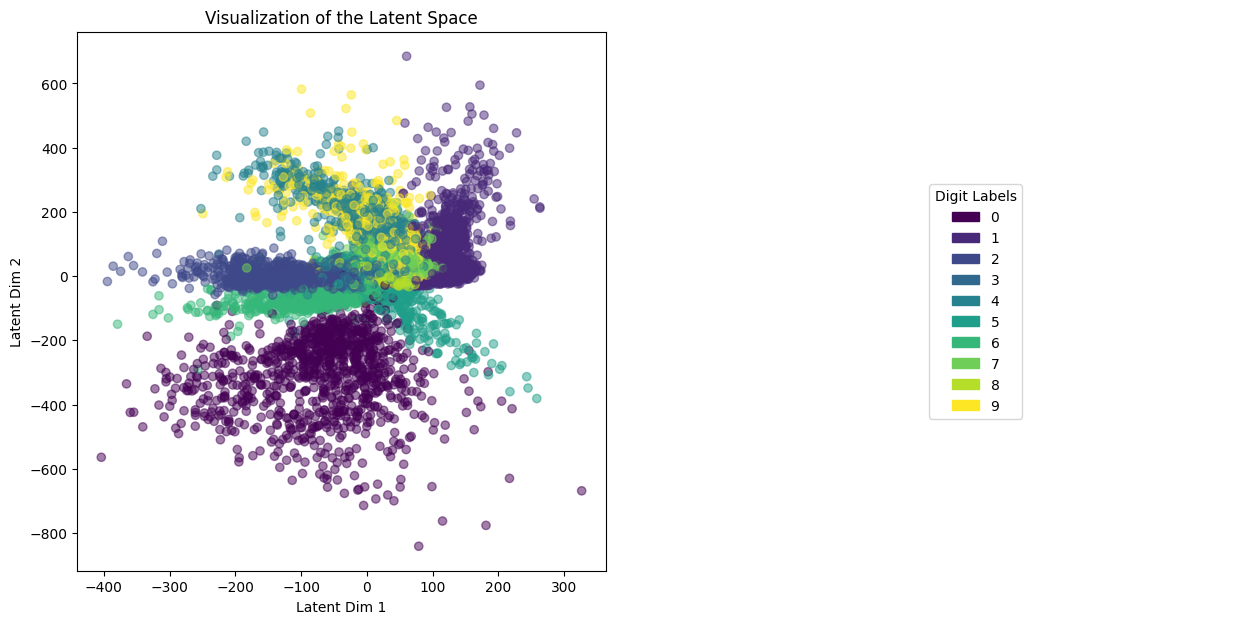

In [15]:
# Generate and visualize decoded images
def plot_images(decoded_images, n=10, figsize=(20, 4)):
    plt.figure(figsize=figsize)
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(decoded_images[i].reshape(image_size, image_size))
        plt.gray()
        ax.axis('off')
    plt.show()

# Sampling from the latent space
n = 10  # Number of samples
z_sample = np.random.normal(size=(n, latent_dim))

# Decode the sampled points (reconstruction only)
decoded_images = decoder.predict(z_sample)

# Plot the generated images
plot_images(decoded_images, n=n)

# Generate a grid of latent space points
n = 15  # Number of points per dimension
grid_start = -6  # Start of the grid
grid_end = 6  # End of the grid
grid_x = np.linspace(grid_start, grid_end, n)
grid_y = np.linspace(grid_end, grid_start, n)  # Reversed order for y
grid = np.array([[x, y] for y in grid_y for x in grid_x])  # Note the order of loops

decoded_images = decoder.predict(grid)

def plot_latent_space_images(images, grid_size, figsize=(15, 15)):
    fig, axes = plt.subplots(grid_size, grid_size, figsize=figsize, subplot_kw={'xticks':[], 'yticks':[]})
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i].reshape(image_size, image_size), cmap='gray')

plot_latent_space_images(decoded_images, n)

# Visualize latent space with label information
z_mean, _, _ = encoder.predict(x_test)

def plot_latent_space_with_label_info(z_mean, labels, figsize=(15, 7)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    # Plotting the latent space
    scatter = ax1.scatter(z_mean[:, 0], z_mean[:, 1], c=labels, cmap='viridis', alpha=0.5)
    ax1.set_xlabel('Latent Dim 1')
    ax1.set_ylabel('Latent Dim 2')
    ax1.set_title('Visualization of the Latent Space')

    # Creating a color legend for labels
    unique_labels = np.unique(labels)
    handles = [mpatches.Patch(color=plt.cm.viridis(label / max(unique_labels)), label=label) for label in unique_labels]
    ax2.legend(handles=handles, title="Digit Labels", loc='center')
    ax2.axis('off')

    plt.show()

plot_latent_space_with_label_info(z_mean, y_test)


## What is the problem in this model?
- in latent space
## Solutions?

==========================================================

## Conditional variational autoencoder.
- VAE can generate very accurate image, but we cannot generate desired digit number. How we can generate some target digit?

In [39]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import (
    Dense, Reshape, Conv2D, MaxPooling2D, Input, UpSampling2D,
    Concatenate, Flatten, Lambda
)
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.models import Model

# Parameters
latent_dim = 2
num_classes = 10
image_size = 28

# Encoder
inputs = Input(shape=(image_size, image_size, 1), name='encoder_input')
label_inputs = Input(shape=(num_classes,), name='label_input')  # One-hot encoded labels

x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
x = Concatenate()([x, label_inputs])  # Concatenate label information
x = Dense(512, activation='relu')(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, name='z')([z_mean, z_log_var])

encoder = Model([inputs, label_inputs], [z_mean, z_log_var, z], name='encoder')

# Decoder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
decoder_label_inputs = Input(shape=(num_classes,), name='decoder_label_input')

x = Concatenate()([latent_inputs, decoder_label_inputs])
x = Dense(7 * 7 * 64, activation='relu')(x)
x = Reshape((7, 7, 64))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
outputs = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

decoder = Model([latent_inputs, decoder_label_inputs], outputs, name='decoder')

# Custom CVAE
class CVAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(CVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        # data: ((x_images, y_labels), x_images)
        (inputs, labels), reconstruction_target = data

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder([inputs, labels])
            reconstruction = self.decoder([z, labels])

            reconstruction_loss = tf.reduce_mean(
                binary_crossentropy(
                    K.flatten(reconstruction_target),
                    K.flatten(reconstruction)
                )
            ) * image_size * image_size

            kl_loss = -0.5 * tf.reduce_sum(
                1 + z_log_var - K.square(z_mean) - K.exp(z_log_var),
                axis=-1
            )
            kl_loss = tf.reduce_mean(kl_loss)

            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

# Instantiate and compile the CVAE
cvae = CVAE(encoder, decoder)
cvae.compile(optimizer='adam')

# Example dataset
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_train = x_train[..., tf.newaxis]  # (60000, 28, 28, 1)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)  # one-hot

# **Important**: pass x=[x_images, one_hot_labels], y=x_images
cvae.fit(
    x=[x_train, y_train],
    y=x_train,
    epochs=10,
    batch_size=128
)


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - kl_loss: 4.3345 - loss: 164.1958 - reconstruction_loss: 159.8613
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - kl_loss: 4.6315 - loss: 135.5015 - reconstruction_loss: 130.8700
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - kl_loss: 4.6631 - loss: 133.5426 - reconstruction_loss: 128.8796
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - kl_loss: 4.6891 - loss: 132.4977 - reconstruction_loss: 127.8085
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - kl_loss: 4.6984 - loss: 131.7513 - reconstruction_loss: 127.0529
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - kl_loss: 4.7054 - loss: 131.1417 - reconstruction_loss: 126.4362
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - kl_loss: 4.7064 - loss: 130.7740 - reconstruction_loss: 126.0676
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - kl_loss: 4.7173 - loss: 130.4181 - reconstruction_loss: 125.7009
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s

| Layer                             | Output Shape   |
|-----------------------------------|----------------|
| Input                             | (28, 28, 1)    |
| Flattened + Concatenate           | (794)          |
| First Dense Layer                 | (3136)         |
| Reshaped to Conv Input            | (7, 7, 64)     |
| First Conv2D                      | (7, 7, 64)     |
| First MaxPooling                  | (4, 4, 64)     |
| Second Conv2D                     | (4, 4, 128)    |
| Flattened Before Dense            | (2048)         |
| Latent Space (z_mean, z_log_var)  | (2)            |
| Decoder Input (Latent + Label)    | (12)           |
| First Dense in Decoder            | (7, 7, 64)     |
| First Upsample + Conv2D           | (14, 14, 64)   |
| Second Conv2D                     | (14, 14, 32)   |
| Conv2DTranspose                   | (28, 28, 32)   |
| Final Conv2D (Output)             | (28, 28, 1)    |


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


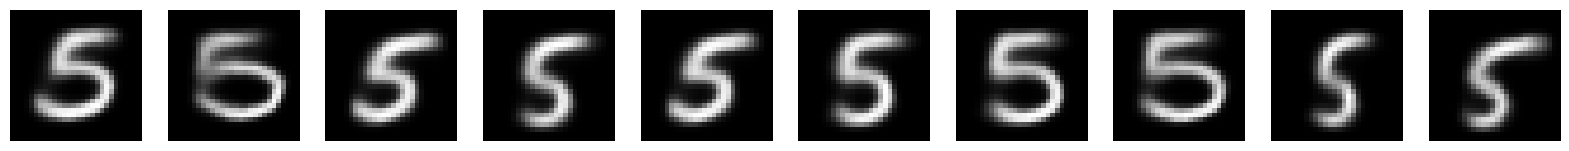

In [41]:
import numpy as np
from tensorflow.keras.utils import to_categorical

num_samples = 10  # The number of samples you want to generate
num_classes = 10  # The total number of classes; 10 for MNIST
latent_dim = 2    # The dimensionality of your latent space

# Sample random points in the latent space
sampled_latent_vectors = np.random.normal(size=(num_samples, latent_dim))

# Create one-hot encoded labels for the desired class
desired_label = 5  # For generating images of the digit '7'
desired_label_one_hot = to_categorical([desired_label] * num_samples, num_classes)

# Generate images from the sampled latent vectors and class labels
generated_images = decoder.predict([sampled_latent_vectors, desired_label_one_hot])

# The shape of generated_images should be (num_samples, 28, 28, 1) if everything is correct
plot_images(generated_images, n=10)

# Homework
From the Fashion mnist dataset:

## 1. Create autoencoder and visualize feature distribution in latent space.

## 2. Create autoencoder with a one hidden layer and multiple CONV layers, then visualize feature distribution in latent space.

## 3. Create variational autoencoder and show feature distribution in latent space.

## 4. Create conditional VAE and show you can create certain class of the image.


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


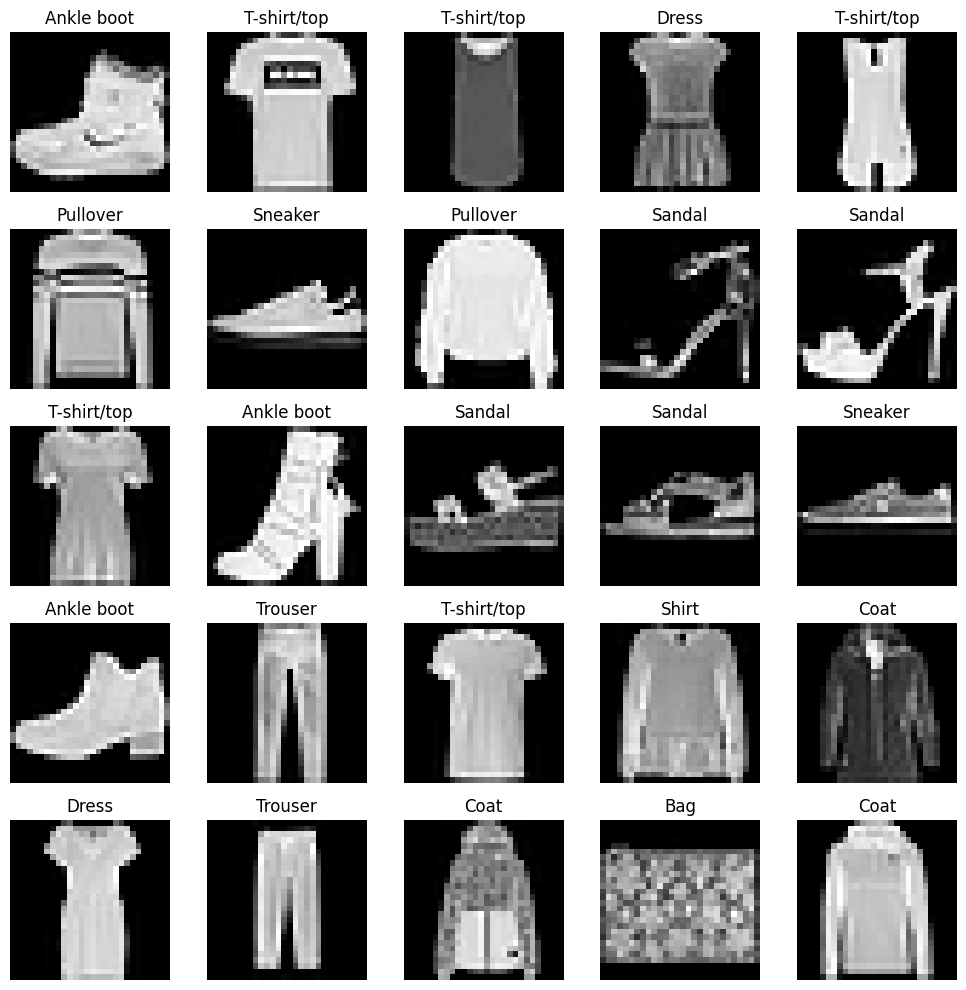

In [42]:
import tensorflow as tf
import matplotlib.pyplot as plt

# 1. Download Fashion MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# 2. Normalize pixel values to [0,1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# 3. Class names for Fashion MNIST
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress",
    "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# 4. Visualize some sample images
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(x_train[i], cmap="gray")
    plt.title(class_names[y_train[i]])
    plt.axis("off")

plt.tight_layout()
plt.show()
